In [1]:
import torch
import os
from VAE_c_gen import BetaVAE
import pandas as pd
import sklearn
import glob, random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import seaborn as sn
import random
import math
import pickle
from torch.autograd import Variable

from torch import nn
from torch.nn import functional as F

from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from torch.optim import SGD, AdamW, Adagrad  # Supported Optimizers
from torch.utils.data import DataLoader

from multiprocessing import cpu_count
from numpy.random import randint

import MLmodels_c_gen as m

from math import floor

# pathways to data files
#trained_model_pw = "r_b3_c2/tb_logs/BVAE_trial/version_0/checkpoints/epoch=199-step=10599.ckpt"
#trained_model_pw = "r_np1_c2/tb_logs/BVAE_trial/version_0/checkpoints/epoch=199-step=18199.ckpt"
trained_model_pw = "r_np3_c2/tb_logs/BVAE_trial/version_0/checkpoints/epoch=199-step=10599.ckpt"
ds_b3_c2 = "./peptide/b3_c2.fasta"
ds_np1_c2 = "./peptide/np1_c2.fasta"
ds_np2_c2 = "./peptide/np2_c2.fasta"
ds_np3_c2 = "./peptide/np3_c2.fasta"

#Configuration
con = {"chem_type": "pept", #pept or dna
              "datatype": None, #if  chem_type is pept, fill in None (dna data analysed before were "HCB20")
              "in_channels": 1,
              "latent_dim": 50,
              "beta": 5,  # # only used if loss_type == "H", beta = 1 is standard VAE
              "gamma": 1,  # only used if loss_type == "B"
              "hidden_dims": [8, 16, 32, 64, 512],
              "max_capacity": 25,  # only used if loss_type == "B"
              "capacity_max_iter": 1e5,  # only used if loss_type == "B"
              "loss_type": "H",  # B or H
              "data_worker_num": 6,
              "optimizer": "AdamW",
              "lr": 1e-3,
              "seed": randint(0, 100000, 1)[0],
              "batch_size": 1000,
              "replicas": 4,  # Number of samples for validation step
              "epochs": 200,
              "attention_layers": False, # This doesn't quite work yet
              "data_file": ds_np3_c2
                }


/home/aneta/anaconda3/envs/buba/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


In [2]:
def predict_vae_beta(dataloader, rd):
    xpss = []
    inputss = []
    n=0
    for i, batch in enumerate(dataloader):
        n=n+1
        seqs, ohe, labels = batch
        seq_aves = []
        pred_aves = []
        replicas = 2
        for _ in range(replicas):
            recon_x, inputs, mu, log_var, encode_attn_maps, decode_attn_maps = model(ohe)
            seq_aves.append(recon_x)
        xp = torch.mean(torch.stack(seq_aves, dim=0), dim=0)
        
        #xp_rn = reshape_normalize(xp)
        #inputs_rn = reshape_normalize(inputs)
        
        #rd_result = get_results(xp_rn,inputs_rn)
        rd_result = get_results(xp,inputs)
    
        torch.save(rd_result,'results%s_%i.pt'%(rd,i))
    return n

def predict_vae_beta2(dataloader, rd):
    xpss = []
    inputss = []
    n=0
    for i, batch in enumerate(dataloader):
        n=n+1
        seqs, ohe = batch
        seq_aves = []
        pred_aves = []
        replicas = 2
        for _ in range(replicas):
            recon_x, inputs, mu, log_var, encode_attn_maps, decode_attn_maps = model(ohe)
            seq_aves.append(recon_x)
        xp = torch.mean(torch.stack(seq_aves, dim=0), dim=0)
        
        #xp_rn = reshape_normalize(xp)
        #inputs_rn = reshape_normalize(inputs)
        
        #rd_result = get_results(xp_rn,inputs_rn)
        rd_result = get_results(xp,inputs)
    
        torch.save(rd_result,'results%s_%i.pt'%(rd,i))
    return n

def load_back_tensors(n,tensor_file,td_vd):
    tnsr_all = []
    for k in range(0,n):
        tnsr = torch.load(tensor_file%(td_vd,k))
        tnsr_all += tnsr
        os.remove(tensor_file%(td_vd,k)) 
    return(tnsr_all)  

#Function to create the Data loader
def create_dataloader(random_set):
    # Load data into dictionaries so we can make them pandas dataframes
    randict = {'sequence':list(random_set.keys()), 'binary':list(random_set.values())}
    # Load dictionarie into pandas dataframe
    _randdict = pd.DataFrame(randict)
    #Make pytorch reader (same is done for training and verification data in each model)
    rand_reader = m.AAReader(_randdict,shuffle=False) #change for DNA
    # Make Data loader
    rand_loader = torch.utils.data.DataLoader(
        rand_reader,
        batch_size=500, #1000
        collate_fn=m.my_collate,
        shuffle=False)
    return(rand_loader)

#Code from helper_tools.py
#Compute log probability of a particular mutant sequence from a pwm and a one-hot encoding
def compute_log_probability(one_hot_seq,pwm):
    prod_mat=np.matmul(one_hot_seq.T,pwm)
    #print(prod_mat)
    #log_prod_mat=np.log(prod_mat)
    sum_diag=np.trace(prod_mat)
    log_sum_diag=np.log(sum_diag)
    return log_sum_diag

def get_results(xps,inps):
    lst = []        
    for i in range(len(xps)):
        log_prob = compute_log_probability(inps[i][0].numpy(),xps[i][0].detach().numpy())
        lst.append(log_prob)
    return lst

In [3]:
#load model
model = BetaVAE(con, debug=False)
print(model.chem_type)

checkpoint = torch.load(trained_model_pw,map_location=torch.device('cpu')) 
model.load_state_dict(checkpoint['state_dict'])  # load checkpoint file
model.prepare_data() 

seqlen 45
convpar 60
BATCH SIZE 1000
pept
train len 52762
validation len 17588
BATCH SIZE 1000


## Generate_new function

In [4]:
new_seqs, aten_maps = model.generate_new()

In [5]:
id_to_base = {
     0:"A",
     1:"R",
     2:"N",
     3:"D",
     4:"C",
     5:"E",
     6:"Q",
     7:"G",
     8:"H",
     9:"I",
     10:"L",
     11:"K",
     12:"M",
     13:"F",
     14:"P",
     15:"S",
     16:"T",
     17:"W",
     18:"Y",
     19:"V",
     20:"-"}

In [7]:
h=0
g=0
for batch in range(5):
    aseq = []
    for i in range(h,h+1000): 
        oseq = []
        for pos in range(len(new_seqs[0][0][0])): #45
            ps = []
            for ak in range(len(new_seqs[0][0])): #21
                ps.append(float(new_seqs[i][0][ak][pos]))
            oseq.append(ps)
        oseq = pd.DataFrame(oseq)
        aseq.append(oseq)
    torch.save(aseq,'aseq%s_%i.pt'%("gd",g))
    h = h+1000
    g = g+1

aseq = load_back_tensors(5,'aseq%s_%i.pt',"gd")

#ngs = []
gener_set = {}
for k in aseq:
    df = k
    qm = np.zeros_like(df.values)
    qm[np.arange(len(df)), df.values.argmax(1)] = 1

    df1 = pd.DataFrame(qm, columns = df.columns).astype(int)
    torch_tensor = torch.tensor(df1.values)
    labels_again = torch.argmax(torch_tensor, dim=1)

    labels_again = torch.argmax(torch_tensor, dim=1)

    fin_seq = []
    for i in (labels_again):
        fin_seq.append(id_to_base[int(i)])
    fin_seq = ''.join(fin_seq)
    #ngs.append(fin_seq)
    gener_set[fin_seq]=0


In [8]:
gd = create_dataloader(gener_set)
n_g = predict_vae_beta(gd,"gd")
results_g = load_back_tensors(n_g,'results%s_%i.pt',"gd")

In [9]:
#LOAD PREVIOUS RESULTS
with open("./comp_results/random_backup_trained_np3_n", "rb") as fp:
   results_r = pickle.load(fp)
with open("./comp_results/np1_backup_trained_np3_n", 'rb') as fp:
    results_np1 = pickle.load(fp)
with open("./comp_results/b3_backup_trained_np3_n", "rb") as fp: 
    results_b3 = pickle.load(fp)
with open("./comp_results/t_backup_trained_np3_n", "rb") as fp: 
    results_t = pickle.load(fp)
with open("./comp_results/v_backup_trained_np3_n", "rb") as fp: 
    results_v = pickle.load(fp)

In [10]:
def Average(lst):
    print (sum(lst) / len(lst))

Average(results_r)
Average(results_g)
Average(results_b3)
Average(results_t)

0.8706171326954619
1.007838285202071
2.4725674467296406
3.0083245253750994


In [11]:
def normalisation_hist(seqs_likelihoods):
    myarray = np.asarray(seqs_likelihoods)
    weights = np.ones_like(myarray)/float(len(myarray))
    return weights

weights_rd = normalisation_hist(results_r)
#weights_np3 = normalisation_hist(results_np3)
weights_np1 = normalisation_hist(results_np1)
weights_b3 = normalisation_hist(results_b3)
weights_t = normalisation_hist(results_t)
weights_v = normalisation_hist(results_v)
weights_g = normalisation_hist(results_g)

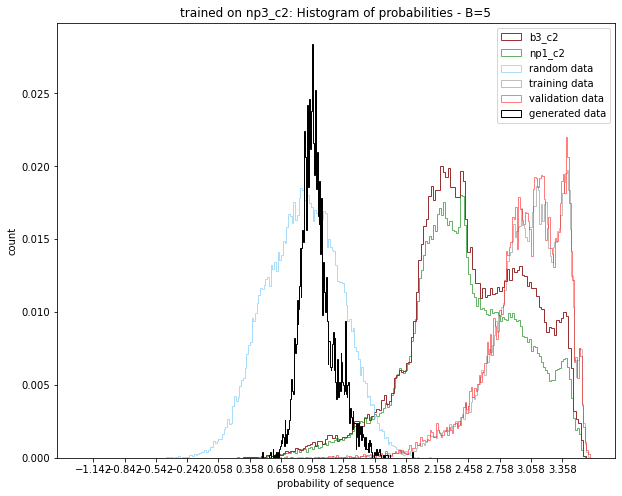

In [12]:
plt.figure(figsize=(10,8))
plt.hist(results_b3,alpha=0.8,bins=200,label="b3_c2", weights = weights_b3, color = "maroon", histtype='step');
plt.hist(results_np1,alpha=0.6,bins=200,label="np1_c2", weights = weights_np1, color = "green", histtype='step');
#plt.hist(results_np3,alpha=0.5,bins=200,label="np3_c2", weights = weights_np3, color = "darkorange", histtype='step');
plt.hist(results_r,alpha=0.7,bins=200,label="random data", weights = weights_rd, color="lightskyblue", histtype='step');
plt.hist(results_t,alpha=0.5,bins=200,label="training data", weights = weights_t, color="grey", histtype='step');
plt.hist(results_v,alpha=0.5,bins=200,label="validation data", weights = weights_v, color="red", histtype='step');
plt.hist(results_g,alpha=1,bins=200,label="generated data", weights = weights_g, color="black", histtype='step');


plt.xlabel("probability of sequence");
plt.ylabel("count")
plt.title("trained on np3_c2: Histogram of probabilities - B=5")
plt.legend();
plt.xticks(np.arange(min(results_b3), max(results_b3), 0.3));

## "pseudoMonteCarlo" version

In [16]:
#generate ranodm seq
def create_random_set(set_size, seq_size):
    random.seed(24)
    random_set = {}
    for _ in range(set_size):
        sequence = ''.join(random.choice("ARNDCEQGHILKMFPSTWYV-") for _ in range(seq_size))
        random_set[sequence]=0
    return random_set

ran_s = create_random_set(1,45)

In [94]:
#get the probability for that sequence
def predict_vae_beta_gen(dataloader, rd):
    n=0
    for i, batch in enumerate(dataloader):
        n=n+1
        seqs, ohe, labels = batch
        seq_aves = []
        pred_aves = []
        replicas = 2
        for _ in range(replicas):
            recon_x, inputs, mu, log_var, encode_attn_maps, decode_attn_maps = model(ohe)
            seq_aves.append(recon_x)
        xp = torch.mean(torch.stack(seq_aves, dim=0), dim=0)
        
        #xp_rn = reshape_normalize(xp)
        #inputs_rn = reshape_normalize(inputs)
        
        #rd_result = get_results(xp_rn,inputs_rn)
        rd_result = get_results(xp,inputs)
    return rd_result

rd = create_dataloader(ran_s)
rslt = predict_vae_beta_gen(rd,"rd")

In [80]:
# iteration process
if rslt[0] > 2.5:
    print("seq found")
else: 
    [[o_seq, val]] = ran_s.items()
    print(o_seq)
    pos = random.randint(0, 44)
    aa = random.choice("ARNDCEQGHILKMFPSTWYV-")
    a_seq = o_seq[:pos] + aa + o_seq[pos+1:]
    ran_sn = {a_seq:0}
    print(ran_sn)
    rd = create_dataloader(ran_s)
    rslt = predict_vae_beta_gen(rd,"rd")

MYEQEQENCIAPP-DATESPISNHVELINW-KRQLLNIDGVCSIH
{'MYEQEQENCIAPP-DATESPISNRVELINW-KRQLLNIDGVCSIH': 0}


In [ ]:
while rslt[0] < 2.0:
    [[o_seq, val]] = ran_s.items()
    #print(o_seq)
    pos = random.randint(0, 44)
    aa = random.choice("ARNDCEQGHILKMFPSTWYV-")
    a_seq = o_seq[:pos] + aa + o_seq[pos+1:]
    ran_sn = {a_seq:0}
    rd = create_dataloader(ran_s)
    rslt_n = predict_vae_beta_gen(rd,"rd")
    if rslt_n > rslt:
        rslt = rslt_n
        o_seq = a_seq
        print(rslt)
#Is very slow to iterate, I had to stop it after some time